In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_files = []
update_list = []

## Helper functions

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [9]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [10]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [11]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [12]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [13]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [14]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [15]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [16]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [17]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [18]:
def remove_ig_genes(adata):
    igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
    igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
    ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
    exl_genes = igl_genes + igk_genes + ighc_genes

    filtered_genes = [gene for gene in adata.var_names if gene not in exl_genes]
    adata = adata[:, filtered_genes]

    return adata

In [19]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()
    
    adata = remove_ig_genes(adata)

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [20]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [21]:
class_markers = [
    'AIM2', # Lower in early memory
    'CD27', # CD27+
    'CD69', # Activated
    'FAS',  # CD95+
    'IGHA1', # Class switching
    'IGHM', # Class switching
    'IGHD', # Class switching
    'IGHG1', # Class switching
    'ITGAX',# CD11c Memory vs Effector
    'MZB1', # Plasmablasts
    'PRDM1',# Plasmablasts
    'TBX21',# Tbet
    'XBP1', # Plasmablasts
    'ZEB2'  #
]

## Read cell type hierarchy

In [22]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [23]:
search_id = 'platinum-gadolinium-calcium'

Retrieve files stored in our HISE project store

In [24]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [25]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [26]:
search_df['AIFI_L3'].tolist()

['Activated memory B cell',
 'CD27- effector B cell',
 'CD27+ effector B cell',
 'CD95 memory B cell',
 'Core memory B cell',
 'Core naive B cell',
 'Early memory B cell',
 'ISG+ naive B cell',
 'Plasma cell',
 'Transitional B cell',
 'Type 2 polarized memory B cell']

# Filter

## Review CD27+ effector B cell

### Proposed updates

- Reassign ZEB2- clusters (8 and 16) to Core Memory B cell
    - Unable to separate 16 from 1, will transfer 8 only

In [27]:
cell_type = 'CD27+ effector B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [28]:
type_uuid

'76c7385f-2043-4a0f-9e25-81afe2acab9b'

In [29]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

downloading fileID: 76c7385f-2043-4a0f-9e25-81afe2acab9b
Files have been successfully downloaded!


In [30]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

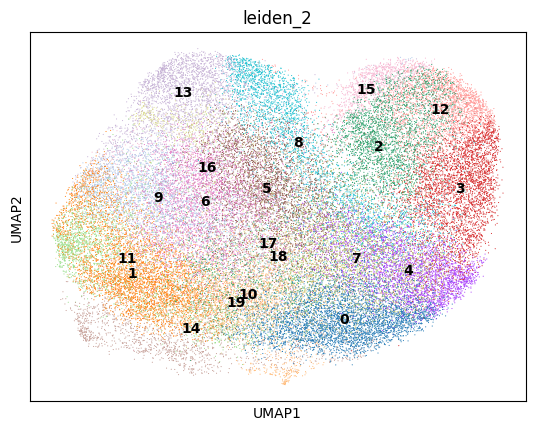

In [31]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

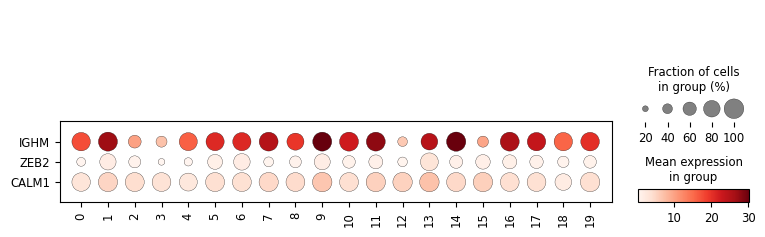

In [32]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['IGHM','ZEB2','CALM1'], swap_axes = True)

### ZEB2- extraction

Extraction

In [33]:
cd27eff_core_adata, n_extracted = extract_cl(
    adata, 'ZEB2', 'below', 0.4, 'leiden_2'
)
n_extracted

['0', '3', '4', '7', '12']


16778

In [34]:
cd27eff_core_adata, n_extracted = extract_cl(
    cd27eff_core_adata, 'IGHM', 'below', 0.8, 'leiden_2'
)
cd27eff_core_adata.obs['AIFI_L3'] = 'Core memory B cell'
n_extracted

['3', '12']


6279

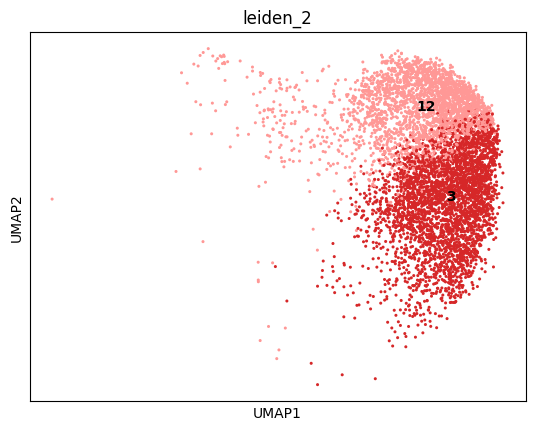

In [35]:
sc.pl.umap(cd27eff_core_adata, color = 'leiden_2', legend_loc = 'on data')

Removal

In [36]:
print(adata.shape)
zeb2_cl = cd27eff_core_adata.obs['leiden_2'].unique()
remove_idx = adata.obs['leiden_2'].isin(zeb2_cl)
keep_idx = [not x for x in remove_idx]
adata = adata[keep_idx]
print(adata.shape)

(49670, 33538)
(43391, 33538)


Reason

In [37]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_extracted],
     'change_to': ['Core memory B cell']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [38]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


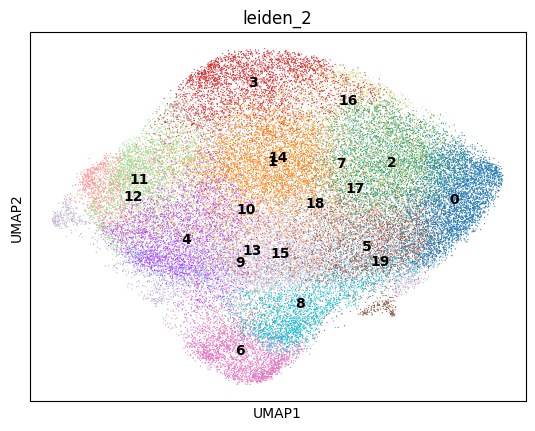

In [39]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [40]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Core naive B cell

### Proposed updates

- Iteratively cluster to remove high LYZ-expressing cluster as possible Myeloid doublet
- Iteratively cluster to remove high PFN-expressing cluster as mislabeled
- Iteratively cluster to extract high AIM2-expressing cells as Core memory B cells.

In [41]:
cell_type = 'Core naive B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [42]:
type_uuid

'c8f341c2-a89e-4bae-ab03-1147e258ca8d'

In [43]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

downloading fileID: c8f341c2-a89e-4bae-ab03-1147e258ca8d
Files have been successfully downloaded!


In [44]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

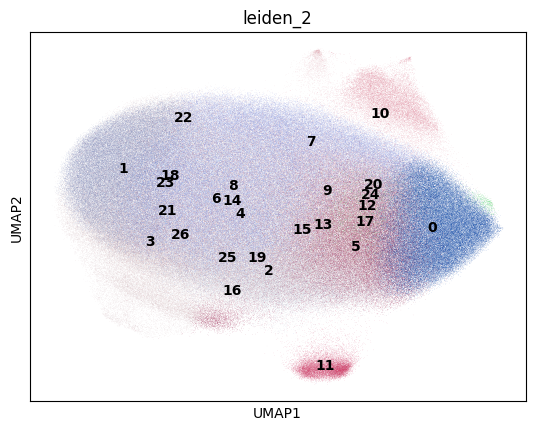

In [45]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

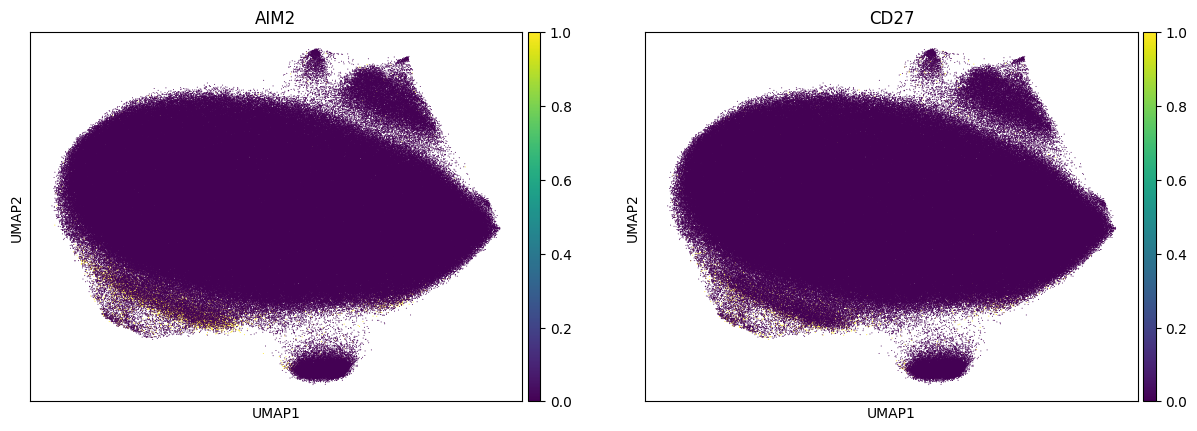

In [46]:
sc.pl.umap(adata, color = ['AIM2', 'CD27'], vmax = 'p99', size = 2)

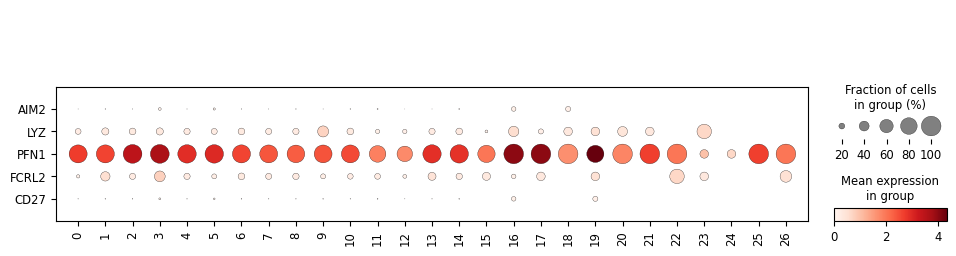

In [47]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['AIM2','LYZ','PFN1','FCRL2','CD27'], swap_axes = True)

### AIM2 extraction

In [48]:
aim2_adata, n_extracted = extract_cl(
    adata, 'AIM2', 'above', 0.05, 'leiden_2'
)
n_extracted

['3', '5', '16', '18']


119295

In [49]:
aim2_adata = process_adata(aim2_adata, resolution = 2)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


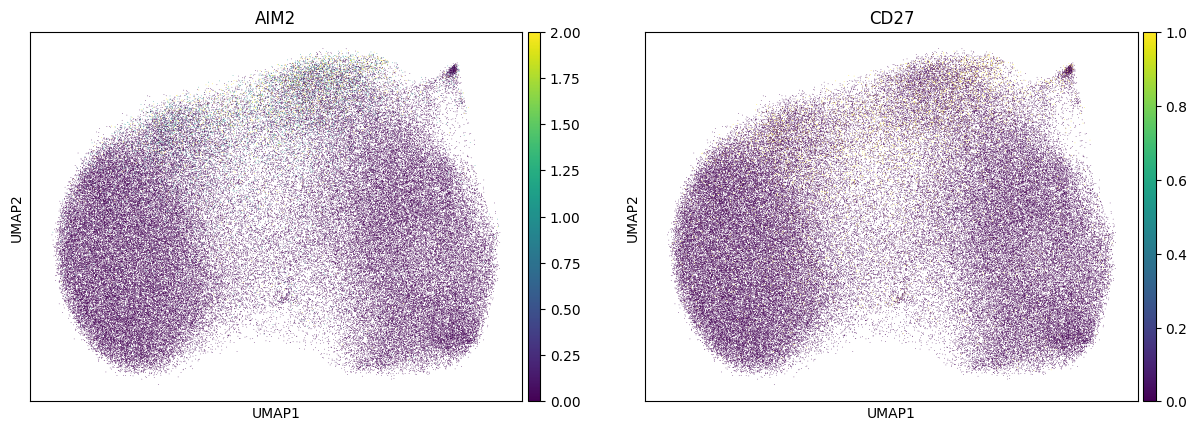

In [50]:
sc.pl.umap(aim2_adata, color = ['AIM2', 'CD27'], vmax = 'p99')

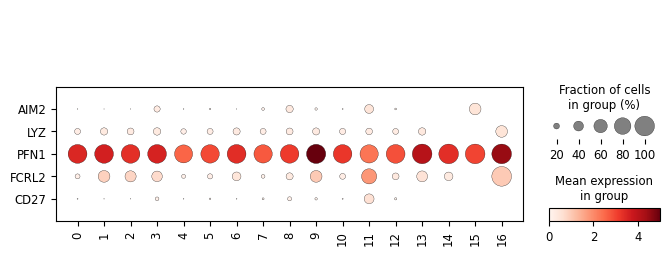

In [51]:
sc.pl.dotplot(aim2_adata, groupby = 'leiden_2', var_names = ['AIM2','LYZ','PFN1','FCRL2','CD27'], swap_axes = True)

In [52]:
aim2_cl = select_clusters_above_gene_frac(aim2_adata, 'AIM2', 0.1, clusters = 'leiden_2')

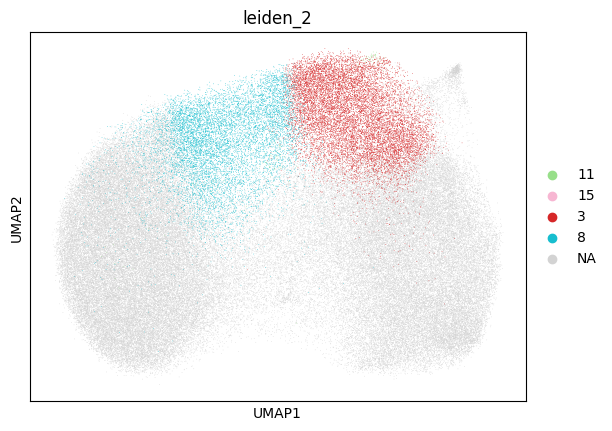

In [53]:
sc.pl.umap(aim2_adata, color = 'leiden_2', groups = aim2_cl)

In [54]:
refined_aim2_bc = aim2_adata.obs['barcodes'].loc[aim2_adata.obs['leiden_2'].isin(aim2_cl)]

In [55]:
refined_aim2_adata = aim2_adata[aim2_adata.obs['leiden_2'].isin(aim2_cl)]

In [56]:
adata.obs['aim2_cells'] = 'no'
adata.obs['aim2_cells'].loc[adata.obs['barcodes'].isin(refined_aim2_bc)] = 'yes'

/tmp/ipykernel_36453/3803260291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['aim2_cells'].loc[adata.obs['barcodes'].isin(refined_aim2_bc)] = 'yes'


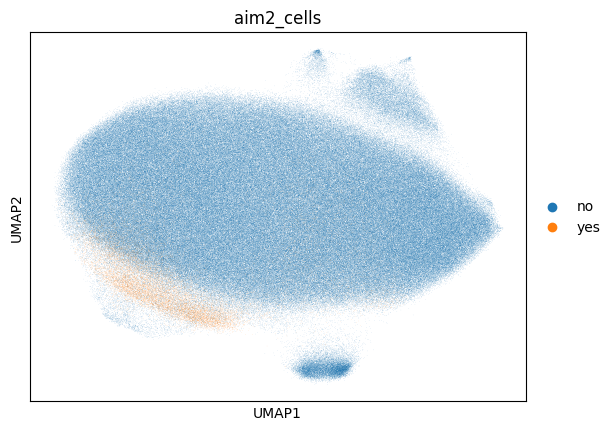

In [57]:
sc.pl.umap(adata, color = 'aim2_cells')

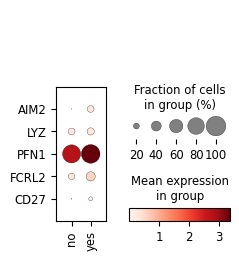

In [58]:
sc.pl.dotplot(adata, groupby = 'aim2_cells', var_names = ['AIM2','LYZ','PFN1','FCRL2','CD27'], swap_axes = True)

### AIM2 removal

In [59]:
adata = adata[adata.obs['aim2_cells'] == 'no']
adata.obs = adata.obs.drop('aim2_cells', axis = 1)

### AIM2 reason

In [60]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [len(refined_aim2_bc)],
     'change_to': ['Core memory B cell']
    }
)
update_list.append(update_df)

### LYZ Selection

Extraction

In [61]:
lyz_adata, n_extracted = extract_cl(
    adata, 'LYZ', 'above', 0.3, 'leiden_2'
)
n_extracted

['9', '16', '19', '20', '21', '23']


39919

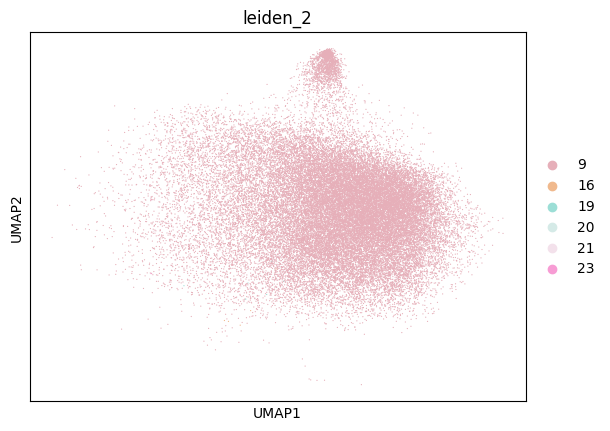

In [62]:
sc.pl.umap(lyz_adata, color = 'leiden_2')

Iterative clustering

In [ ]:
lyz_adata = process_adata(lyz_adata, resolution = 2)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; 

In [ ]:
sc.pl.umap(lyz_adata, color = 'leiden_2', legend_loc = 'on data')

Marker expression

In [ ]:
sc.pl.dotplot(lyz_adata, groupby = 'leiden_2', var_names = ['AIM2','LYZ','PFN1','GPBP1'], swap_axes = True)

### LYZ Iterative selection

In [ ]:
lyz_adata, n_extracted = extract_cl(
    lyz_adata, 'LYZ', 'above', 0.6, 'leiden_2'
)
n_extracted

### LYZ Removal

In [ ]:
drop_idx = adata.obs['barcodes'].isin(lyz_adata.obs['barcodes'])
keep_idx = [not x for x in drop_idx]
adata = adata[keep_idx]

### LYZ Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_extracted],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### FCRL2 Selection

Extraction

In [ ]:
fcrl2_adata, n_extracted = extract_cl(
    adata, 'FCRL2', 'above', 0.4, 'leiden_2'
)
n_extracted

In [ ]:
sc.pl.umap(fcrl2_adata, color = 'leiden_2')

Iterative clustering

In [ ]:
fcrl2_adata = process_adata(fcrl2_adata, resolution = 2)

In [ ]:
sc.pl.umap(fcrl2_adata, color = 'leiden_2', legend_loc = 'on data')

Marker expression

In [ ]:
sc.pl.dotplot(fcrl2_adata, groupby = 'leiden_2', var_names = ['AIM2','LYZ','PFN1','CLECL1'], swap_axes = True)

In [ ]:
sc.pl.umap(fcrl2_adata, color = 'CLECL1', vmax = 'p99')

### CLECL1 Iterative selection

In [ ]:
clecl1_adata, n_extracted = extract_cl(
    fcrl2_adata, 'CLECL1', 'above', 0.4, 'leiden_2'
)
n_extracted

### CLECL1 Removal

In [ ]:
drop_idx = adata.obs['barcodes'].isin(clecl1_adata.obs['barcodes'])
keep_idx = [not x for x in drop_idx]
adata = adata[keep_idx]

### CLECL1 Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_extracted],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ naive B cell

### Proposed updates

- Remove high FCN1 cluster (21) as myeloid doublet
- Remove high CD3D cluster (22) as T cell doublet

In [ ]:
cell_type = 'ISG+ naive B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['FCN1','CD3D'], swap_axes = True)

### FCN1 selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.2, 'leiden_2'
)
n_removed

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### CD3D selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.4, 'leiden_2'
)
n_removed

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Filter Plasma cell

### Proposed updates

- Remove CD20/MS4A1+ cluster Mislabeled B cells

In [ ]:
cell_type = 'Plasma cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['MS4A1'], swap_axes = True)

### MS4A1 selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'MS4A1', 'above', 0.6, 'leiden_2'
)
n_removed

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Mislabeled MS4A1+']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

# Integrate

## Review Core memory B cell

### Proposed updates

- Integrate cells from CD27+ effector B cells

In [ ]:
cell_type = 'Core memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Add cells to integrate

In [ ]:
adata = sc.concat([adata, cd27eff_core_adata])

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Integrate Early memory B cell

### Proposed updates

- Integrate AIM2+ cells from Core naive B cells
- Filter to remove TRAC+ cells as T cell doublets

In [ ]:
cell_type = 'Early memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Add cells to integrate

In [ ]:
adata = sc.concat([adata, refined_aim2_adata])

### Reprocess Integrated cells

In [ ]:
adata = process_adata(adata, resolution = 2)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'TRAC', vmax = 'p99')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['TRAC'], swap_axes = True)

### TRAC selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'TRAC', 'above', 0.4, 'leiden_2'
)
n_removed

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

# No updates

## Pass-through Activated Memory B

### Proposed updates

- Integrate cells from AIM2+ naive B cells

In [ ]:
cell_type = 'Activated memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
refined_aim2_adata

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through CD27- effector B cell

### Proposed updates

No proposed changes

In [ ]:
cell_type = 'CD27- effector B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through CD95 memory B cell

### Proposed updates

- No changes

In [ ]:
cell_type = 'CD95 memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through Transitional B cell

### Proposed updates

No proposed changes

In [ ]:
cell_type = 'Transitional B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through Type 2 polarized memory B cell

### Proposed updates

No proposed changes

In [ ]:
cell_type = 'Type 2 polarized memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [ ]:
update_df = pd.concat(update_list)

In [ ]:
update_df

In [ ]:
out_update = 'output/diha_filtered_celltypist_L3_B_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [161]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 B cell Filtering {d}'.format(d = date.today())

In [162]:
search_id = element_id()
search_id

'nihonium-curium-niobium'

In [163]:
in_files = search_df['id'].tolist()
in_files = in_files + [hierarchy_uuid]

In [164]:
out_files = out_files

In [165]:
out_files

['output/diha_filtered_celltypist_L3_CD27pos_effector_B_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_Core_naive_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_naive_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Plasma_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Core_memory_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Early_memory_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Activated_memory_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_CD27neg_effector_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_CD95_memory_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Transitional_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Type_2_polarized_memory_B_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_B_reasons_2024-04-24.csv']

In [166]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

you are trying to upload file_ids... ['output/diha_filtered_celltypist_L3_CD27pos_effector_B_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_Core_naive_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_ISGpos_naive_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Plasma_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Core_memory_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Early_memory_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Activated_memory_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_CD27neg_effector_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_CD95_memory_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Transitional_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Type_2_polarized_memory_B_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_B_reasons_2024-04-24.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': '9fb2d032-56d9-4610-b90a-ee37d3f62fad',
 'files': ['output/diha_filtered_celltypist_L3_CD27pos_effector_B_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_Core_naive_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_ISGpos_naive_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Plasma_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Core_memory_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Early_memory_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Activated_memory_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_CD27neg_effector_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_CD95_memory_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Transitional_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Type_2_polarized_memory_B_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_B_reasons_2024-04-24.csv']}

In [167]:
import session_info
session_info.show()